In [1]:
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input,
    GlobalAveragePooling2D,
    Dense,
    BatchNormalization,
    Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, classification_report

warnings.filterwarnings('ignore')


In [2]:
# -----------------------------------
# 1. Ustawienia i ścieżki
# -----------------------------------
image_shape = (224, 224)
batch_size  = 32
epochs_stage1 = 10
epochs_stage2 = 5

data_path    = r'C:/Users/Ania/Desktop/dataset2/archive (1)/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'
train_folder = os.path.join(data_path, 'train')
valid_folder = os.path.join(data_path, 'valid')
test_folder  = os.path.join(data_path, 'test')


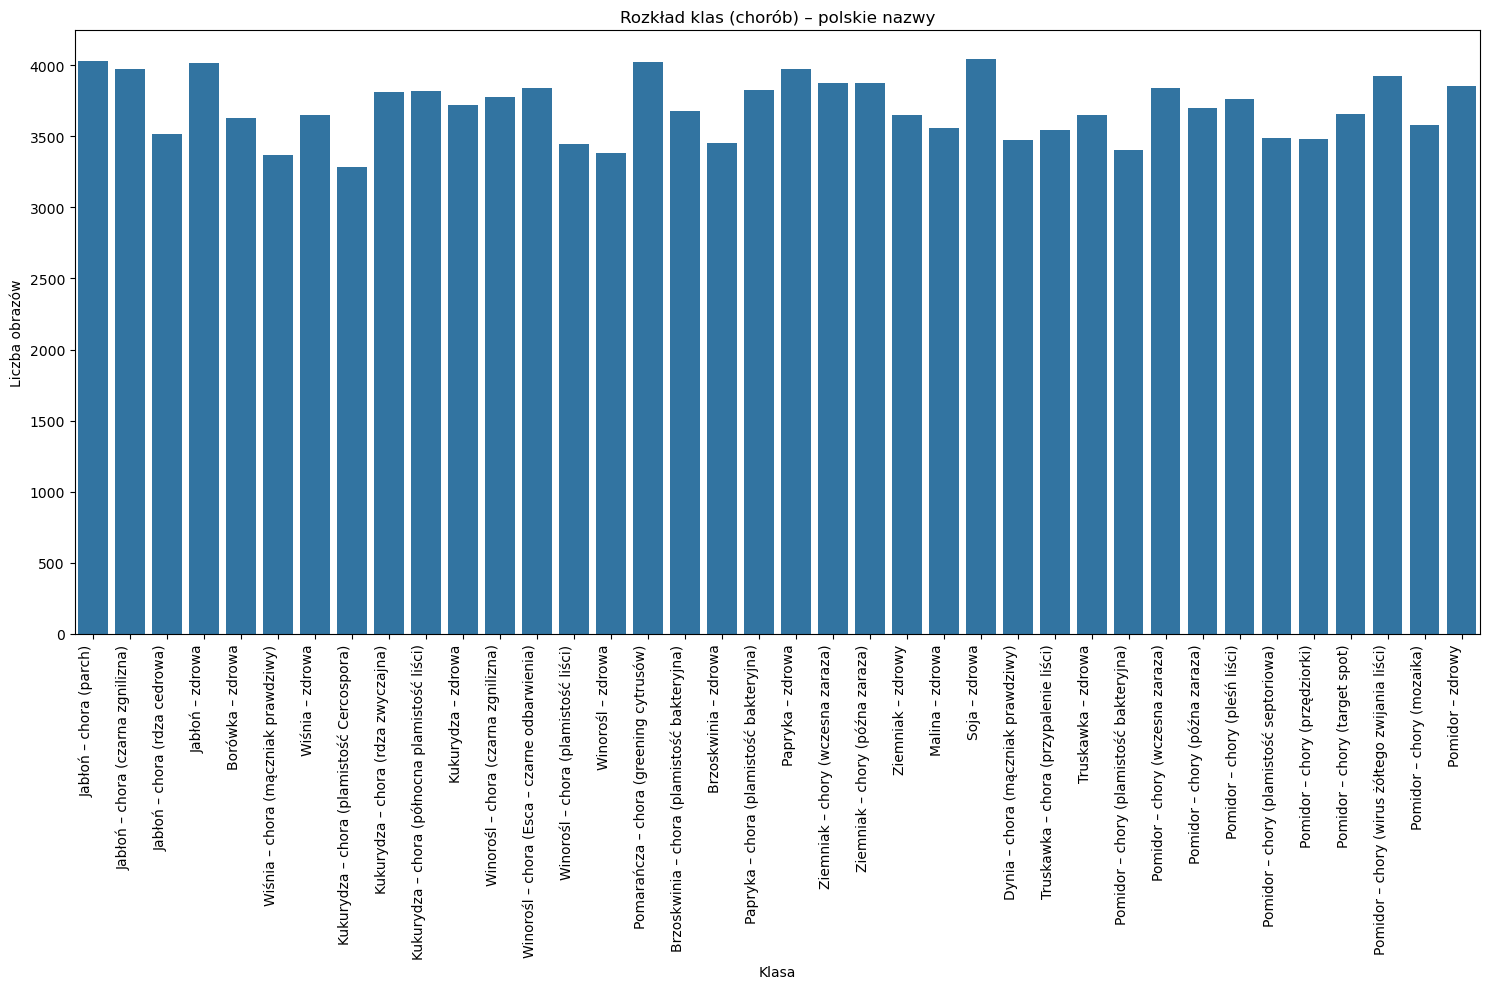

In [25]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Pobranie i posortowanie listy folderów z nazwami klas (angielskie nazwy folderów)
diseases = sorted(os.listdir(train_folder))

# 2. Lista polskich nazw klas w tej samej kolejności co sorted(diseases)
class_names = [
    'Jabłoń – chora (parch)', 'Jabłoń – chora (czarna zgnilizna)', 'Jabłoń – chora (rdza cedrowa)', 'Jabłoń – zdrowa',
    'Borówka – zdrowa', 'Wiśnia – chora (mączniak prawdziwy)', 'Wiśnia – zdrowa',
    'Kukurydza – chora (plamistość Cercospora)', 'Kukurydza – chora (rdza zwyczajna)',
    'Kukurydza – chora (północna plamistość liści)', 'Kukurydza – zdrowa',
    'Winorośl – chora (czarna zgnilizna)', 'Winorośl – chora (Esca – czarne odbarwienia)',
    'Winorośl – chora (plamistość liści)', 'Winorośl – zdrowa',
    'Pomarańcza – chora (greening cytrusów)', 'Brzoskwinia – chora (plamistość bakteryjna)',
    'Brzoskwinia – zdrowa', 'Papryka – chora (plamistość bakteryjna)', 'Papryka – zdrowa',
    'Ziemniak – chory (wczesna zaraza)', 'Ziemniak – chory (późna zaraza)', 'Ziemniak – zdrowy',
    'Malina – zdrowa', 'Soja – zdrowa', 'Dynia – chora (mączniak prawdziwy)',
    'Truskawka – chora (przypalenie liści)', 'Truskawka – zdrowa',
    'Pomidor – chory (plamistość bakteryjna)', 'Pomidor – chory (wczesna zaraza)', 'Pomidor – chory (późna zaraza)',
    'Pomidor – chory (pleśń liści)', 'Pomidor – chory (plamistość septoriowa)',
    'Pomidor – chory (przędziorki)', 'Pomidor – chory (target spot)',
    'Pomidor – chory (wirus żółtego zwijania liści)', 'Pomidor – chory (mozaika)', 'Pomidor – zdrowy'
]

# Sprawdźmy, czy liczba folderów i liczba polskich nazw się zgadza
assert len(diseases) == len(class_names), "Lista polskich nazw musi mieć tyle samo elementów, co lista folderów."

# 3. Wyliczenie liczby obrazów w każdej klasie
class_counts = {}
for idx, cls in enumerate(diseases):
    path = os.path.join(train_folder, cls)
    # Zakładam, że w folderze są tylko pliki obrazów (jpg/png), bez podkatalogów
    count = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
    class_counts[class_names[idx]] = count

# 4. Przygotowanie DataFrame do wykresu
df = pd.DataFrame({
    "Klasa": list(class_counts.keys()),
    "Liczba obrazów": list(class_counts.values())
})

# 5. Rysowanie wykresu słupkowego
plt.figure(figsize=(15, 10))
sns.barplot(data=df, x="Klasa", y="Liczba obrazów")
plt.xticks(rotation=90, ha="right")
plt.title("Rozkład klas (chorób)")
plt.tight_layout()
plt.show()


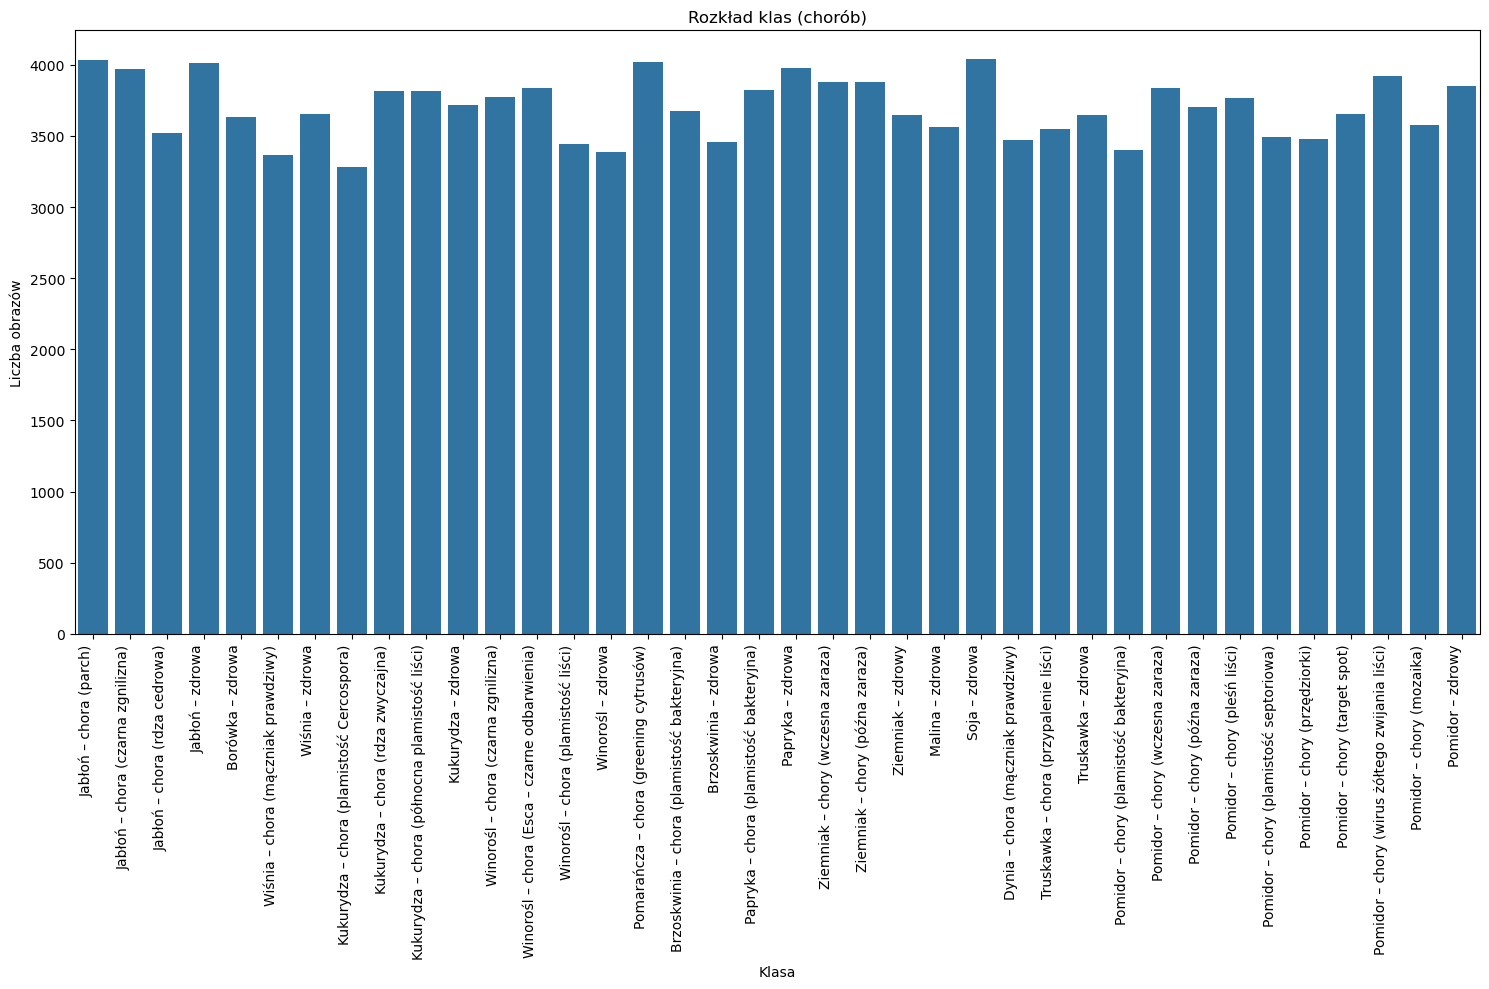

In [36]:
# 5. Rysowanie wykresu słupkowego
plt.figure(figsize=(15, 10))
sns.barplot(data=df, x="Klasa", y="Liczba obrazów")
plt.xticks(rotation=90, ha="right")
plt.title("Rozkład klas (chorób)")
plt.tight_layout()
plt.show()

In [5]:
# -----------------------------------
# 2. Generatory danych z augmentacją i preprocess_input
# -----------------------------------
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_data = train_datagen.flow_from_directory(
    train_folder,
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

valid_data = valid_datagen.flow_from_directory(
    valid_folder,
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_data = test_datagen.flow_from_directory(
    test_folder,
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

print(f"Train: {train_data.samples} obrazów w {train_data.num_classes} klasach")
print(f"Valid: {valid_data.samples} obrazów w {valid_data.num_classes} klasach")
print(f"Test:  {test_data.samples} obrazów w {test_data.num_classes} klasach")

num_classes = train_data.num_classes


Found 140590 images belonging to 38 classes.
Found 34384 images belonging to 38 classes.
Found 760 images belonging to 38 classes.
Train: 140590 obrazów w 38 klasach
Valid: 34384 obrazów w 38 klasach
Test:  760 obrazów w 38 klasach


In [18]:

# -----------------------------------
# 3. Budowa modelu ResNet50 + głębszy head z L2 i Dropout
# -----------------------------------
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(image_shape[0], image_shape[1], 3)
)
base_model.trainable = False

inputs = Input(shape=(image_shape[0], image_shape[1], 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)

# * GŁĘBSZY HEAD identyczny jak w „wspaniałym” EfficientNetB0 *
x = Dense(512, activation='relu',
          kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu',
          kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(num_classes, activation='softmax')(x)

model_resnet = Model(inputs=inputs, outputs=outputs)

model_resnet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_resnet.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 38)                  │           4,902 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,808,998 (94.64 MB)

 Trainable params: 1,219,750 (4.65 MB)

 Non-trainable params: 23,589,248 (89.99 MB)

In [22]:

# -----------------------------------
# 4. Callbacks: ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# -----------------------------------
checkpoint_1 = ModelCheckpoint(
    'resnet50_stage1_best.keras',    # <- zmienione rozszerzenie
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)
early_stop_1 = EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    restore_best_weights=True
)
reduce_lr_1 = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=1,
    min_lr=1e-6
)



Epoch 1/10
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 11904s 3s/step - accuracy: 0.5760 - loss: 1.7303 - val_accuracy: 0.9513 - val_loss: 0.2625 - learning_rate: 1.0000e-04
Epoch 2/10
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 11891s 3s/step - accuracy: 0.9124 - loss: 0.3903 - val_accuracy: 0.9670 - val_loss: 0.1996 - learning_rate: 1.0000e-04
Epoch 3/10
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 12031s 3s/step - accuracy: 0.9374 - loss: 0.2954 - val_accuracy: 0.9741 - val_loss: 0.1695 - learning_rate: 1.0000e-04
Epoch 4/10
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 11890s 3s/step - accuracy: 0.9500 - loss: 0.2471 - val_accuracy: 0.9752 - val_loss: 0.1622 - learning_rate: 1.0000e-04
Epoch 5/10
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 11888s 3s/step - accuracy: 0.9557 - loss: 0.2219 - val_accuracy: 0.9784 - val_loss: 0.1451 - learning_rate: 1.0000e-04
Epoch 6/10
4394/4394 ━━━━━━━━━━━━━━━━━━━━ 11801s 3s/step - accuracy: 0.9601 - loss: 0.2004 - val_accuracy: 0.9783 - val_loss: 0.1395 - learning_rate: 1.0000e-04
Epoch 7/10
4394/4394 ━━━━━━━━━━━━━

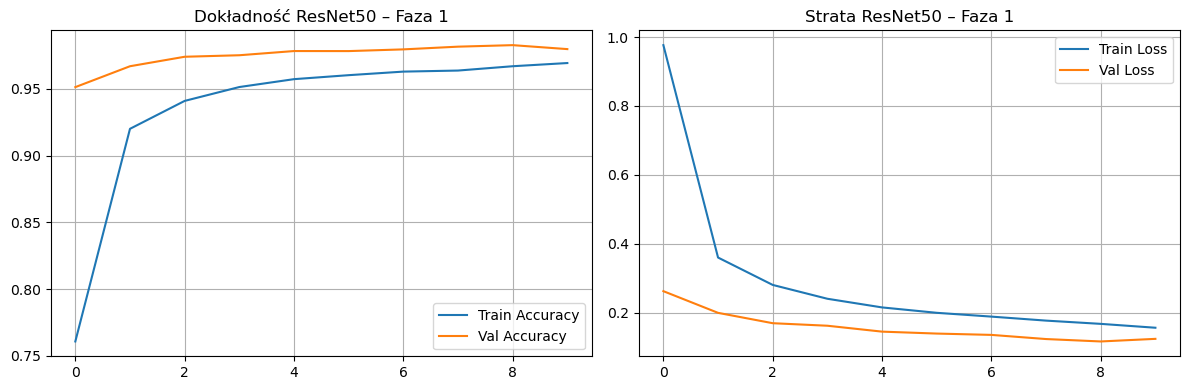

In [24]:
# -----------------------------------
# 5. Etap 1: Trening tylko “head” (base_model zamrożony)
# -----------------------------------
history_stage1 = model_resnet.fit(
    train_data,
    validation_data=valid_data,
    epochs=epochs_stage1,
    callbacks=[checkpoint_1, early_stop_1, reduce_lr_1]
)

# Wyświetlenie krzywych uczenia po fazie 1
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_stage1.history['accuracy'], label='Train Accuracy')
plt.plot(history_stage1.history['val_accuracy'], label='Val Accuracy')
plt.title('Dokładność ResNet50 – Faza 1')
plt.legend(), plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history_stage1.history['loss'], label='Train Loss')
plt.plot(history_stage1.history['val_loss'], label='Val Loss')
plt.title('Strata ResNet50 – Faza 1')
plt.legend(), plt.grid()

plt.tight_layout()
plt.show()



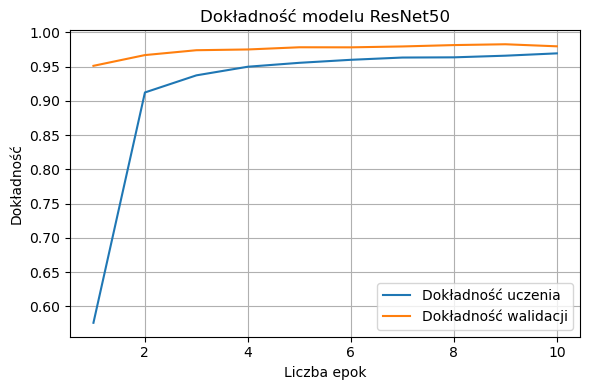

In [1]:
import matplotlib.pyplot as plt

# Dokładność z treningu i walidacji
dokladnosc_uczenia = [0.5760, 0.9124, 0.9374, 0.9500, 0.9557, 0.9601, 0.9634, 0.9637, 0.9661, 0.9695]
dokladnosc_walidacji = [0.9513, 0.9670, 0.9741, 0.9752, 0.9784, 0.9783, 0.9796, 0.9816, 0.9828, 0.9798]

epoki = list(range(1, 11))

plt.figure(figsize=(6, 4))

plt.plot(epoki, dokladnosc_uczenia, label='Dokładność uczenia')
plt.plot(epoki, dokladnosc_walidacji, label='Dokładność walidacji')
plt.title('Dokładność modelu ResNet50')
plt.xlabel('Liczba epok')
plt.ylabel('Dokładność')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [28]:
# -----------------------------------
# 6. Ładowanie najlepszego checkpointu z Etapu 1
# -----------------------------------
model_resnet = load_model('resnet50_stage1_best.keras')



In [32]:
# -----------------------------------
# 9. Ocena na zbiorze testowym
# -----------------------------------
test_loss, test_acc = model_resnet.evaluate(test_data, verbose=1)
print(f"\nResNet50 (po fine-tuning) – Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9921 - loss: 0.0925

ResNet50 (po fine-tuning) – Test Accuracy: 0.9842, Test Loss: 0.1167


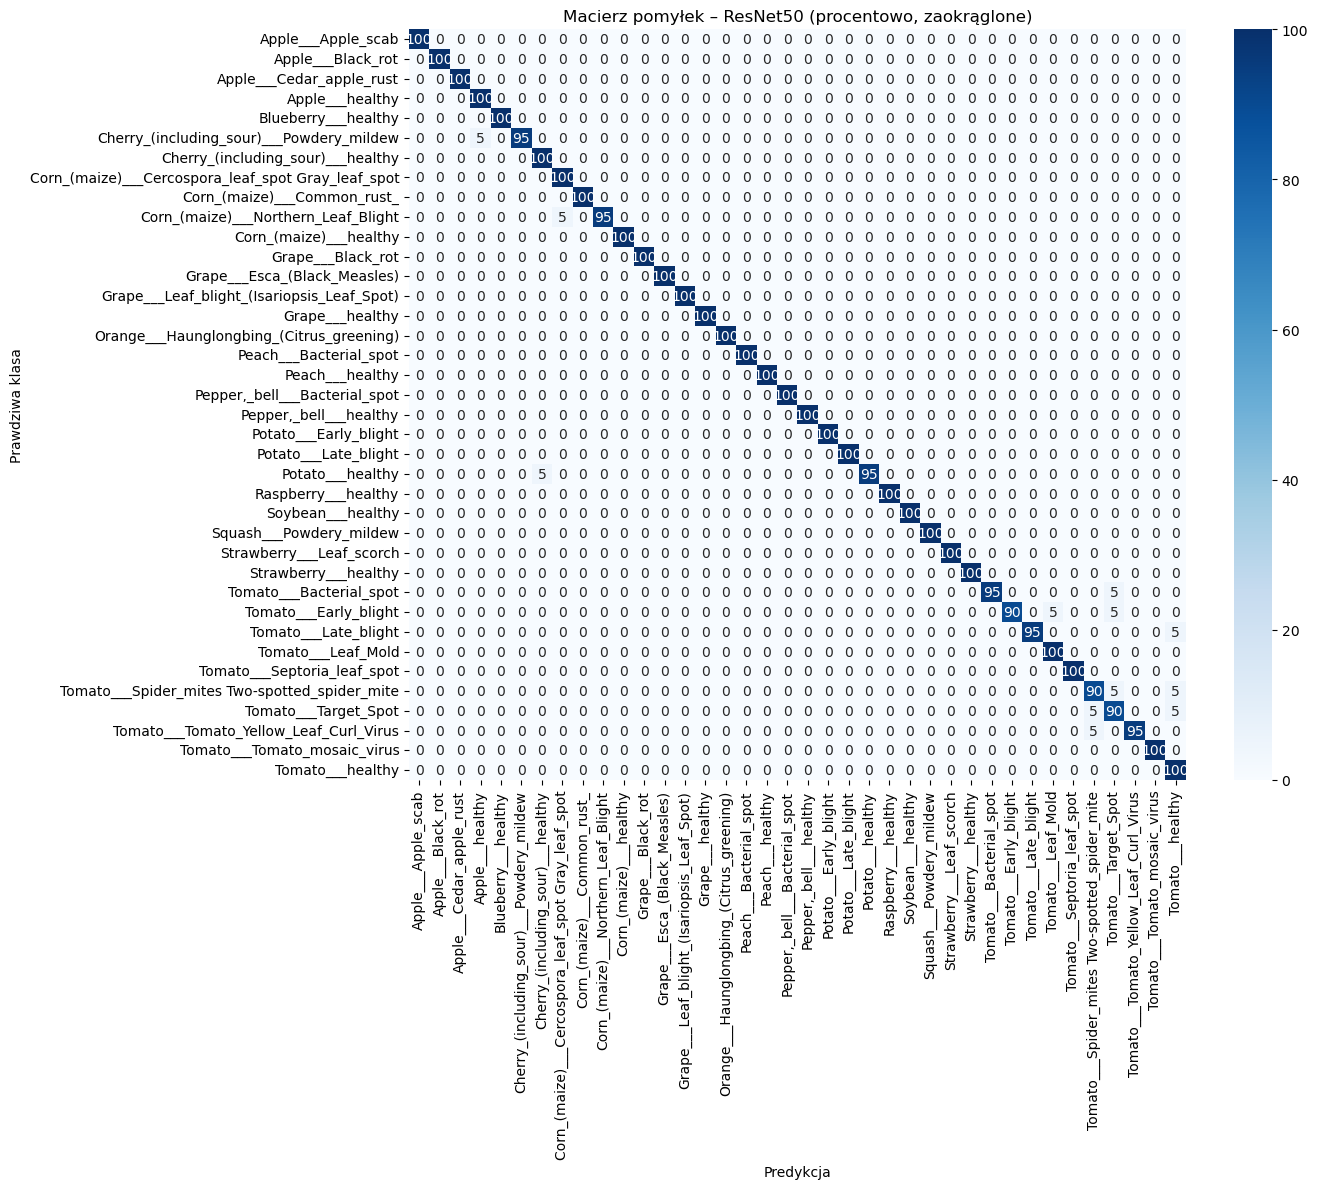


===== Raport klasyfikacji (Precision, Recall, F1) =====

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      1.00      1.00        20
                                 Apple___Black_rot       1.00      1.00      1.00        20
                          Apple___Cedar_apple_rust       1.00      1.00      1.00        20
                                   Apple___healthy       0.95      1.00      0.98        20
                               Blueberry___healthy       1.00      1.00      1.00        20
          Cherry_(including_sour)___Powdery_mildew       1.00      0.95      0.97        20
                 Cherry_(including_sour)___healthy       0.95      1.00      0.98        20
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.95      1.00      0.98        20
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00        20
               Corn_(

In [33]:

# -----------------------------------
# 10. Macierz pomyłek i raport klasyfikacji
# -----------------------------------
# Klasy pobieramy z test_data.class_indices
class_names = list(test_data.class_indices.keys())

y_true = []
y_pred = []

for i in range(len(test_data)):
    x_batch, y_batch = test_data[i]
    preds = model_resnet.predict(x_batch, verbose=0)

    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

    # Zatrzymujemy się, gdy przekroczymy liczbę próbek
    if (i + 1) * test_data.batch_size >= test_data.samples:
        break

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # w %

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt='.0f',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title("Macierz pomyłek – ResNet50 (procentowo, zaokrąglone)")
plt.xlabel("Predykcja")
plt.ylabel("Prawdziwa klasa")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\n===== Raport klasyfikacji (Precision, Recall, F1) =====\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=class_names
))


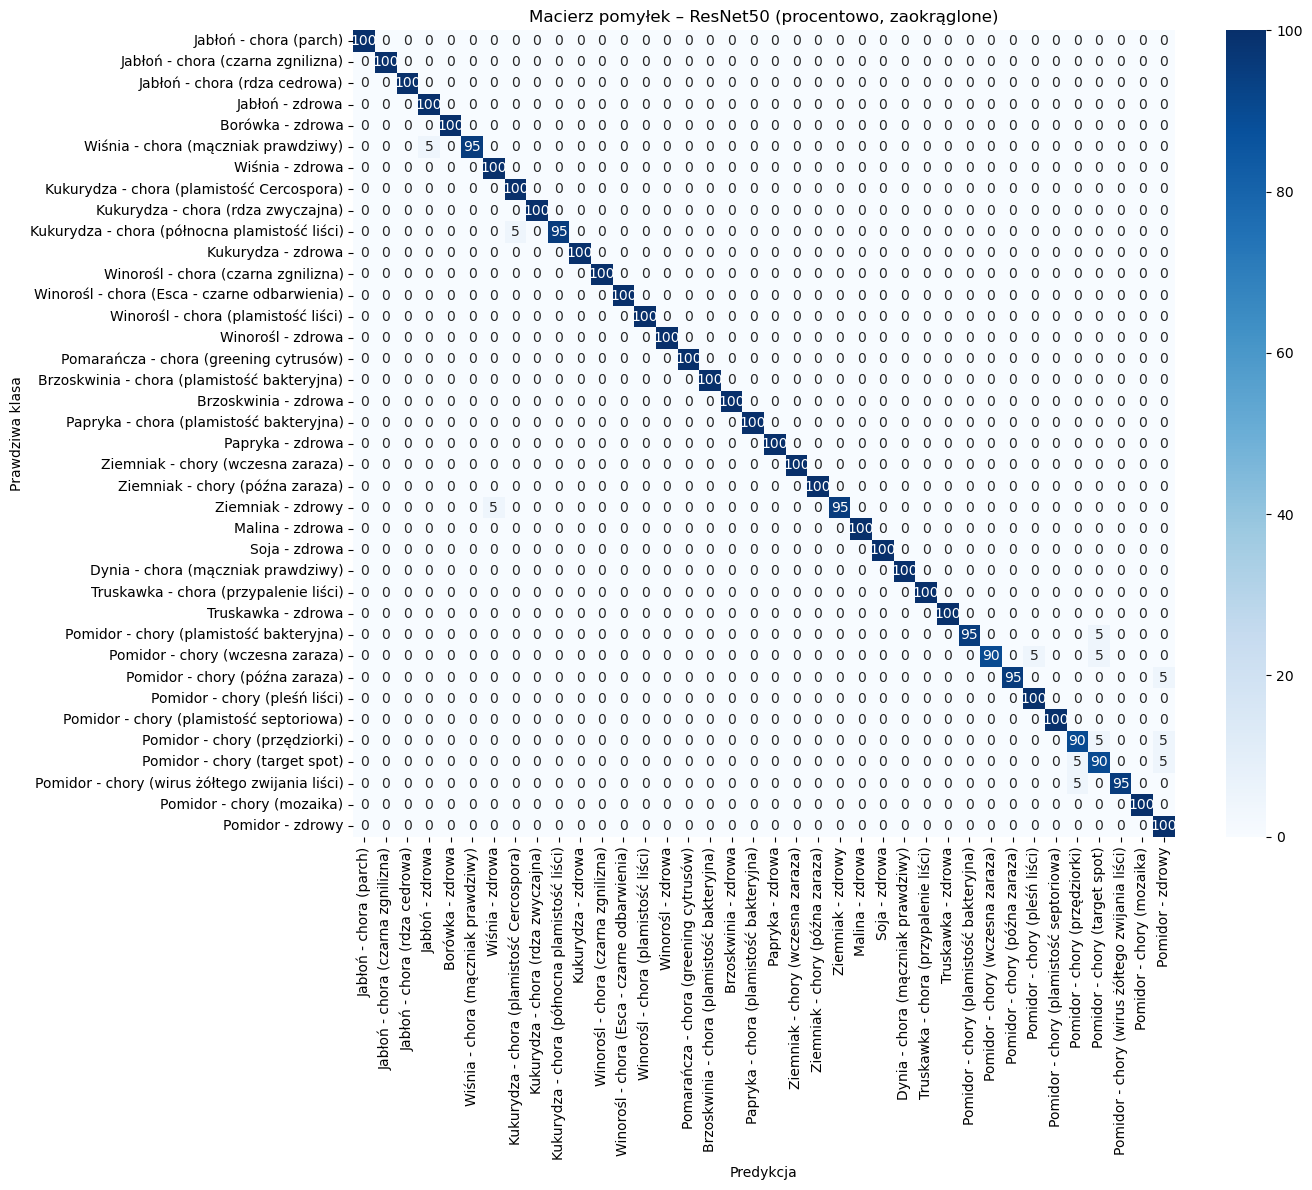

In [38]:
class_names_pl = [
    'Jabłoń - chora (parch)', 'Jabłoń - chora (czarna zgnilizna)', 'Jabłoń - chora (rdza cedrowa)', 'Jabłoń - zdrowa',
    'Borówka - zdrowa', 'Wiśnia - chora (mączniak prawdziwy)', 'Wiśnia - zdrowa',
    'Kukurydza - chora (plamistość Cercospora)', 'Kukurydza - chora (rdza zwyczajna)',
    'Kukurydza - chora (północna plamistość liści)', 'Kukurydza - zdrowa',
    'Winorośl - chora (czarna zgnilizna)', 'Winorośl - chora (Esca - czarne odbarwienia)',
    'Winorośl - chora (plamistość liści)', 'Winorośl - zdrowa',
    'Pomarańcza - chora (greening cytrusów)', 'Brzoskwinia - chora (plamistość bakteryjna)',
    'Brzoskwinia - zdrowa', 'Papryka - chora (plamistość bakteryjna)', 'Papryka - zdrowa',
    'Ziemniak - chory (wczesna zaraza)', 'Ziemniak - chory (późna zaraza)', 'Ziemniak - zdrowy',
    'Malina - zdrowa', 'Soja - zdrowa', 'Dynia - chora (mączniak prawdziwy)',
    'Truskawka - chora (przypalenie liści)', 'Truskawka - zdrowa',
    'Pomidor - chory (plamistość bakteryjna)', 'Pomidor - chory (wczesna zaraza)', 'Pomidor - chory (późna zaraza)',
    'Pomidor - chory (pleśń liści)', 'Pomidor - chory (plamistość septoriowa)',
    'Pomidor - chory (przędziorki)', 'Pomidor - chory (target spot)',
    'Pomidor - chory (wirus żółtego zwijania liści)', 'Pomidor - chory (mozaika)', 'Pomidor - zdrowy'
]

#macierz pomyłek
cm = confusion_matrix(y_true, y_pred)

#normalizowana w % (zaokrąglona)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

#pokaż macierz
plt.figure(figsize=(14, 12))
sns.heatmap(cm_normalized, annot=True, fmt='.0f', cmap='Blues',
            xticklabels=class_names_pl, yticklabels=class_names_pl)
plt.title("Macierz pomyłek – ResNet50 (procentowo, zaokrąglone)")
plt.xlabel("Predykcja")
plt.ylabel("Prawdziwa klasa")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [7]:
from tensorflow.keras.models import load_model

model = load_model("resnet50_stage1_best.keras")
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# Przewidywane etykiety jako argmax
y_pred_probs = model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)

# Prawdziwe etykiety
y_true = test_data.classes

# Nazwy klas
class_labels = list(test_data.class_indices.keys())

# Raport klasyfikacji
report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)
print(report)

# Dokładność ogólna
print("Dokładność ogólna:", accuracy_score(y_true, y_pred))


24/24 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab     1.0000    1.0000    1.0000        20
                                 Apple___Black_rot     1.0000    1.0000    1.0000        20
                          Apple___Cedar_apple_rust     1.0000    1.0000    1.0000        20
                                   Apple___healthy     0.9524    1.0000    0.9756        20
                               Blueberry___healthy     1.0000    1.0000    1.0000        20
          Cherry_(including_sour)___Powdery_mildew     1.0000    0.9500    0.9744        20
                 Cherry_(including_sour)___healthy     0.9524    1.0000    0.9756        20
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     0.9524    1.0000    0.9756        20
                       Corn_(maize)___Common_rust_     1.0000    1.0000    1.0000        20
               Corn_(maize)___Northern_L

In [9]:
from tensorflow.keras.models import load_model

model = load_model("resnet50_stage1_best.keras")
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# Przewidywane etykiety jako argmax
y_pred_probs = model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)

# Prawdziwe etykiety
y_true = test_data.classes

# Nazwy klas
class_labels = list(test_data.class_indices.keys())

# Raport klasyfikacji
report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)
print(report)

# Dokładność ogólna
print("Dokładność ogólna:", accuracy_score(y_true, y_pred))

24/24 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab     1.0000    1.0000    1.0000        20
                                 Apple___Black_rot     1.0000    1.0000    1.0000        20
                          Apple___Cedar_apple_rust     1.0000    1.0000    1.0000        20
                                   Apple___healthy     0.9524    1.0000    0.9756        20
                               Blueberry___healthy     1.0000    1.0000    1.0000        20
          Cherry_(including_sour)___Powdery_mildew     1.0000    0.9500    0.9744        20
                 Cherry_(including_sour)___healthy     0.9524    1.0000    0.9756        20
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     0.9524    1.0000    0.9756        20
                       Corn_(maize)___Common_rust_     1.0000    1.0000    1.0000        20
               Corn_(maize)___Northern_L